In [1]:
# import necessary libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Read ultimate_data_challenge.json and save it to a dataframe
with open('ultimate_data_challenge.json', 'r') as json_file:
    json_data = json.load(json_file)
    
df = pd.DataFrame(json_data)

# Print the first five rows
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [2]:
# Transform last trip date and signup date to datetime format 
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

# Add a new column retained. This column is the response variable. It is True if the difference between last trip date
# and sign up date is more than 5 months
df['retained'] = (df.last_trip_date-df.signup_date).apply(lambda x:x.days>150)

In [3]:
# Delete last trip date because it is of no use anymore
del df['last_trip_date']

In [4]:
# Print the percentage of positive and negative value of the response variable.
df['retained'].value_counts(normalize=True)

False    0.75604
True     0.24396
Name: retained, dtype: float64

#### The data is imbalanced

In [5]:
# Print df.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 3.9+ MB


## Categorical and Boolean Features
#### For each categorical and Boolean feature, a bar plot is drawn to show the distribution of retained ratio for each level of the feature. If the distribution does not significantly change across different levels, it indicates the feature does not impact the response variable and could be removed.

In [6]:
# Define a function which creates the bar plot
def bar_plot(feature,figure_size=(8,4),label_rotation= 'horizontal'):
    """This function creates a bar plot for each categorical feature which shows the distribution of the 
    retained ratio across all levels of the feature."""
    (df.groupby(feature)['retained'].mean().sort_values()).plot.bar(figsize = figure_size)
    plt.xlabel(feature)
    plt.xticks(rotation=label_rotation)
    plt.ylabel('retained ratio')
    plt.title('Retained ratio across all levels of {}'.format(feature))
    plt.show()

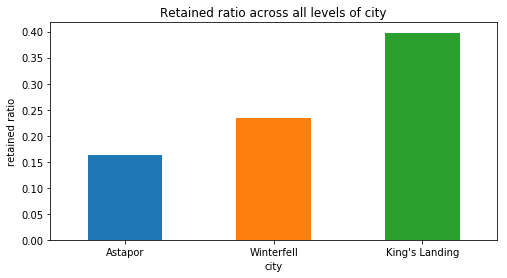

In [7]:
# Run bar_plot on city
bar_plot('city')

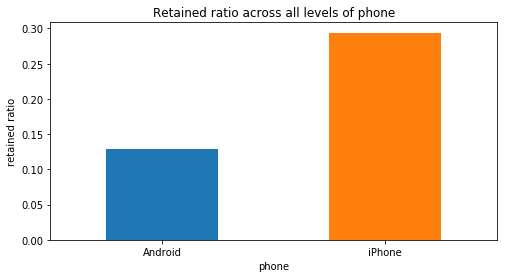

In [8]:
# Fill null values with forward fill method
df.phone.fillna(method='ffill',inplace=True)

# Run bar_plot on phone
bar_plot('phone')

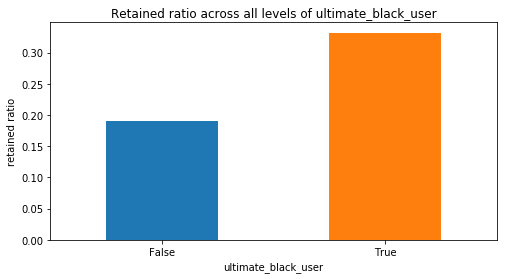

In [9]:
# Transform 'ultimate_black_user' from Boolean to string
df['ultimate_black_user']=df['ultimate_black_user'].astype('str')

# Run bar_plot on ultimate_black_user
bar_plot('ultimate_black_user')

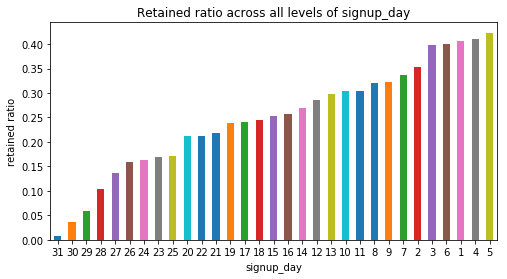

In [10]:
# Save the day of signup in a new column
df['signup_day'] = df.signup_date.apply(lambda x:x.day).astype('str')

# Delete sigup_date
del df['signup_date']

# Run bar_plot on signup_day
bar_plot('signup_day')

#### Bar plots of four categorical variables are showing they are all important in predicting the response variable and must be kept.

## Numerical Features

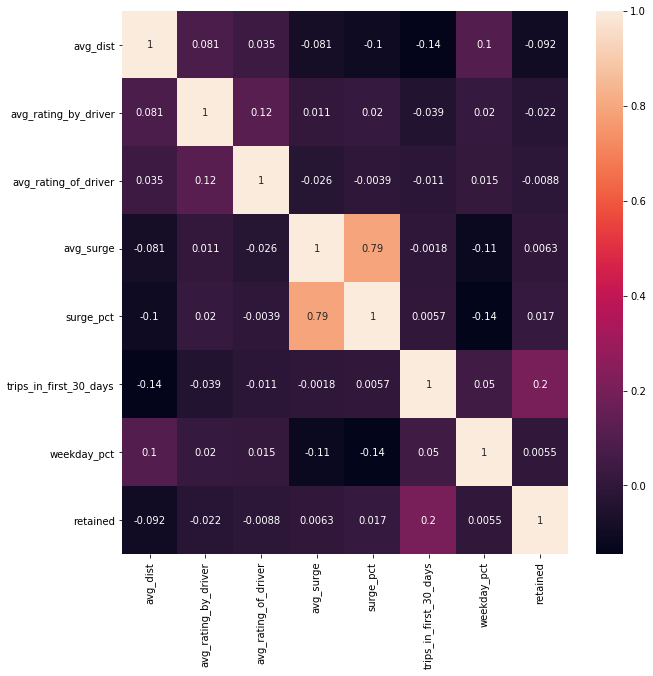

In [11]:
# Plot heatmap of numerical features to find highly correlated features.
plt.figure(figsize=(10,10))
corr=df.corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 10})
plt.show()

#### There is no significantly highly correlated (more than 0.9) numerical features.

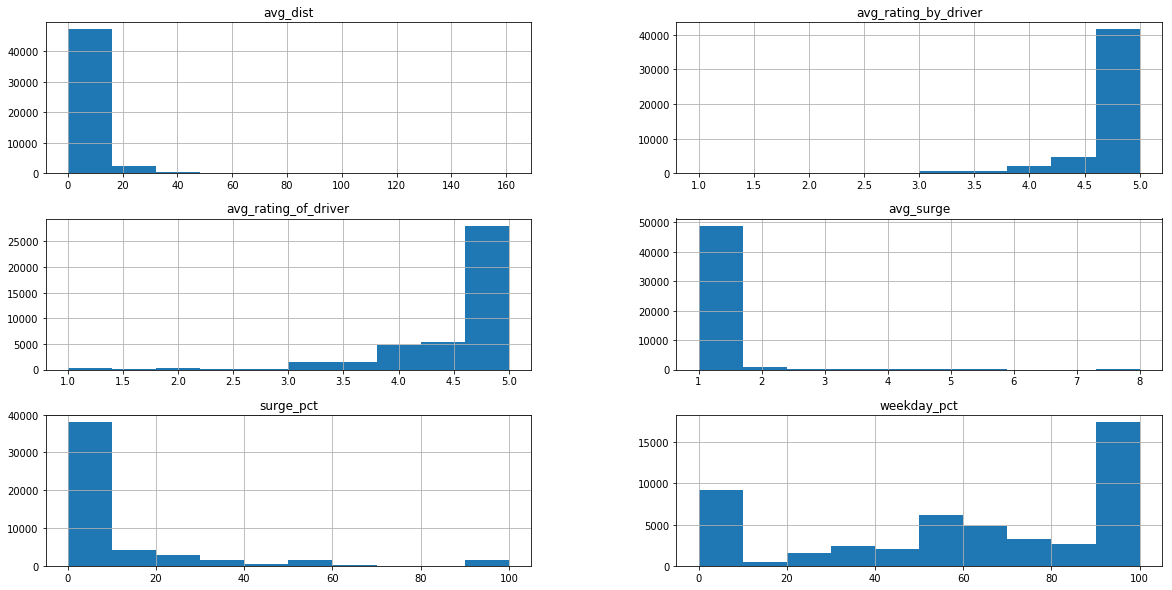

In [12]:
# Create list of numerical features
numerical_list = df.dtypes[df.dtypes=='float64'].index

# Create histogram of numerical variables
df.loc[:,numerical_list].hist(figsize=(20,10))
plt.show()

#### All numerical values except 'weekday_pct' have outliers and are highly skewed. At first, a conservative threshold is applied to remove outliers

In [14]:
# A value will be capped if it is more than 99th percentile or the outlier threshold by box plot 
# (which is 75th percentile plus 1.5 interquartile range) whichever is larger.
# A value will be floored if it is less than 1th percentile or the outlier threshold by box plot 
# (which is 25th percentile minus 1.5 interquartile range) whichever is smaller. 

def cap_floor(dataframe=df):
    """This function caps and floors outliers in each feature. A value is capped by 99th percentile or 
    the outlier threshold by box plot (which is 75th percentile plus 1.5 interquartile range) whichever is larger.
    A value is floored if it is less than 1th percentile or the outlier threshold by box plot 
    (which is 25th percentile minus 1.5 interquartile range) whichever is smaller"""
    skewed_list = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct']
    df_copy = dataframe.copy()
    # Separate numerical features
    for feature in skewed_list:
        # Define different quantiles and IQR
        q1 = dataframe[feature].quantile(0.01)
        q25 = dataframe[feature].quantile(0.25)
        q75 = dataframe[feature].quantile(0.75)
        q99 = dataframe[feature].quantile(0.99)
        iqr = q75-q25
        lower_limit = min(q1,q25-1.5*iqr)
        upper_limit = max(q99,q75+1.5*iqr)
        df_copy[feature].clip(lower_limit,upper_limit,inplace=True)
    return df_copy

# Apply cap_floor function on df
df = cap_floor(df)

#### Coxbox and logarithmic transformation did not improve skewness. Therefore, the highly skewed features are discretize. The original format of the data will still be kept.

In [53]:
# First define a function which plots histogram of the input feature of df
def hist_plot(feature,bin_input=10,range_input=1):
    """"This function plots the histogram of the input feature of df. If no range_input is provided,
    the function will use min and max of the feature"""""
    
    if range_input==1:
        df[feature].hist(bins=bin_input,range=(df[feature].min(),df[feature].max()),figsize=(8,4))
    else:
        df[feature].hist(bins=bin_input,range=range_input,figsize=(8,4))
                        
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.title('Histogram of {}'.format(feature))
    
# Then, define a function which bins the input feature to discrete intervals with the input bins list and apply bar_plot
# Also it removes '()',']', and ', ' from the interval; this is necessary to use the features in XGBoost classifier
def binning(feature,bins,figure_size=(8,4)):
    df[feature+'_bins']=pd.cut(df[feature],bins=bins).astype('str').str.replace('(','').str.replace(']','').str.replace(', ','_')
    listt=['{}_{}'.format(float(bins[m]),float(bins[m+1])) for m in range(len(bins)-1)]
    group=df.groupby(feature+'_bins')['retained'].mean()
    group.loc[listt].plot.bar(figsize=figure_size)
    plt.xlabel(feature+'_bins')
    plt.xticks(rotation='horizontal')
    plt.ylabel('retained ratio')
    plt.title('Retained ratio across all levels of {}'.format(feature+'_bins'))
    plt.show()

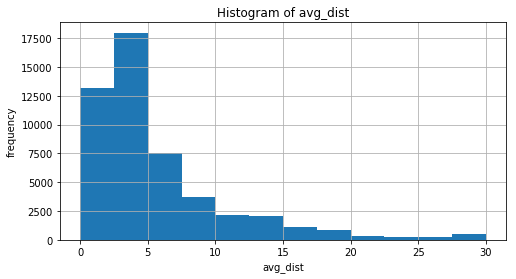

In [54]:
# Plot histogram of avg_dist
hist_plot('avg_dist',12,(0,30))

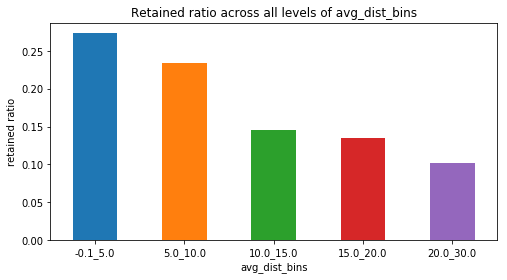

In [55]:
# Apply binning function on avg_dist
bins=[-0.1,5,10,15,20,30]
binning('avg_dist',bins)

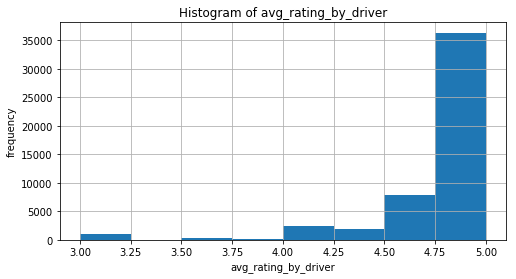

In [56]:
# Fill null values of avg_rating_by_driver with median
df['avg_rating_by_driver'].fillna(value=df['avg_rating_by_driver'].median(),inplace=True)

# Plot histogram of avg_rating_by_driver 
hist_plot('avg_rating_by_driver',8)

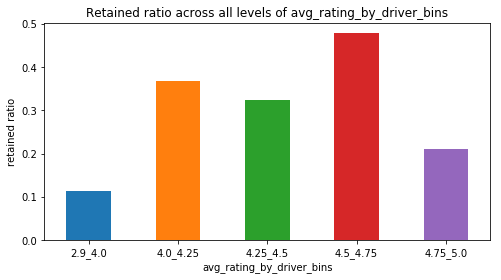

In [61]:
# Apply binning function on avg_rating_by_driver
bins=[2.9,4,4.25,4.5,4.75,5]
binning('avg_rating_by_driver',bins)

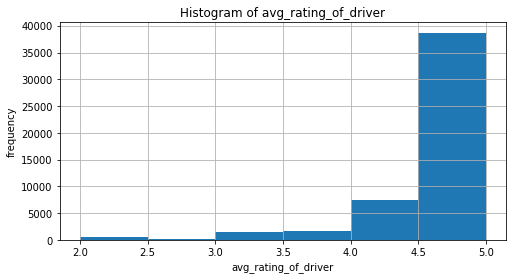

In [62]:
# Fill null values of avg_rating_of_driver with median
df['avg_rating_of_driver'].fillna(value=df['avg_rating_of_driver'].median(),inplace=True)

# Plot histogram of avg_rating_by_driver 
hist_plot('avg_rating_of_driver',6)

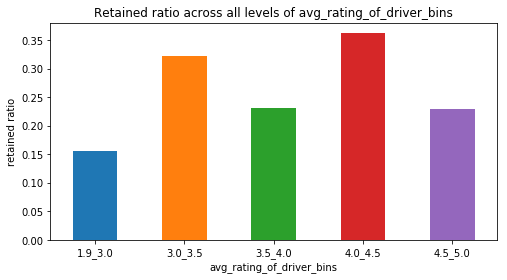

In [63]:
# Apply binning function on avg_rating_of_driver
bins=[1.9,3,3.5,4,4.5,5]
binning('avg_rating_of_driver',bins)

In [64]:
# Run value_count on avg_surge
df['avg_surge'].value_counts(normalize=True).head(3)

1.00    0.68908
1.25    0.02200
1.13    0.01912
Name: avg_surge, dtype: float64

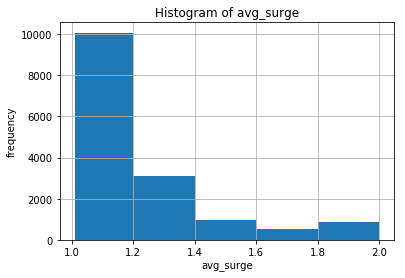

In [65]:
# Separate value of 1 and plot histogram of the rest
df['avg_surge'][df['avg_surge']>=1.01].hist(bins=[1.01,1.2,1.4,1.6,1.8,2])
plt.xlabel('avg_surge')
plt.ylabel('frequency')
plt.title('Histogram of avg_surge')
plt.show()

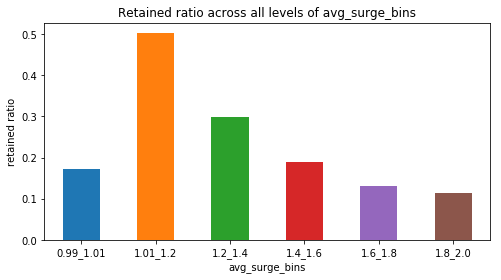

In [66]:
# Apply binning function on avg_surge
bins=[0.99,1.01,1.2,1.4,1.6,1.8,2]
binning('avg_surge',bins)

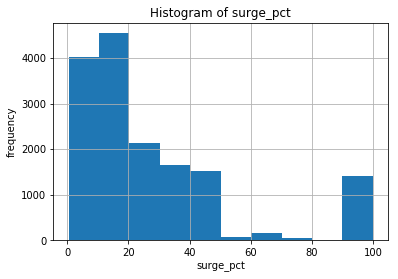

In [67]:
# Every row with avg_surge value of 1, has surge_pct value of 0.
# Plot histogram of surg_pct>0
df['surge_pct'][df['surge_pct']>=0.01].hist()
plt.xlabel('surge_pct')
plt.ylabel('frequency')
plt.title('Histogram of surge_pct')
plt.show()

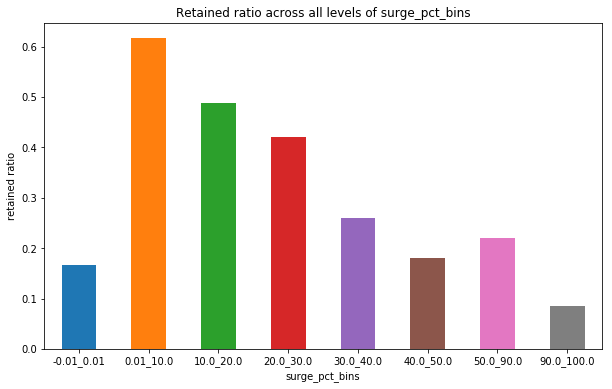

In [68]:
# Apply binning function on surge_pct
bins=[-0.01,0.01,10,20,30,40,50,90,100]
binning('surge_pct',bins,figure_size=(10,6))

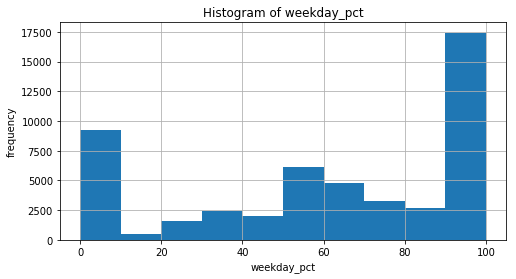

In [69]:
# Since every numerical feature except 'weekday_pct' is discretized, 'weekday_pct' will be discretized too to make the 
# analysis of logistic regression model easier
# Plot histogram of weekday_pct
hist_plot('weekday_pct')

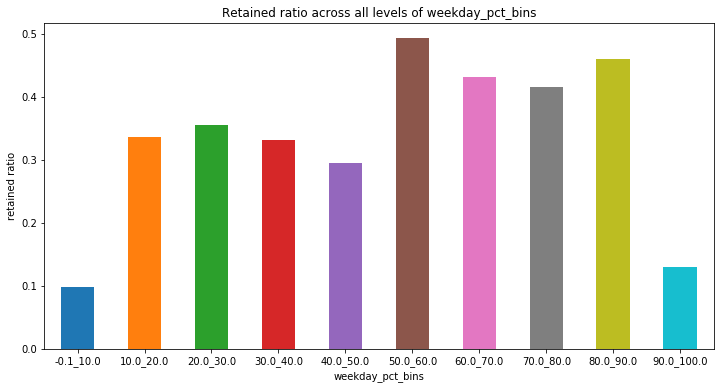

In [70]:
# Apply binning function on weekday_pct
bins=[-0.1,10,20,30,40,50,60,70,80,90,100]
binning('weekday_pct',bins,figure_size=(12,6))

## Predictive model

In [71]:
df.dtypes

avg_dist                     float64
avg_rating_by_driver         float64
avg_rating_of_driver         float64
avg_surge                    float64
city                          object
phone                         object
surge_pct                    float64
trips_in_first_30_days         int64
ultimate_black_user           object
weekday_pct                  float64
retained                        bool
signup_day                    object
avg_dist_bins                 object
avg_rating_by_driver_bins     object
avg_rating_of_driver_bins     object
avg_surge_bins                object
surge_pct_bins                object
weekday_pct_bins              object
dtype: object

In [75]:
# Create three lists: categorical and Boolean features, numerical features, and discretized numerical features
categorical = ['city','phone','ultimate_black_user','signup_day']
numerical = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct']
numerical_bin = [feature+'_bins' for feature in numerical]

# Create feature dataframe and response variable series
X1 = df.loc[:,categorical+numerical] # Feature dataframe 1
X2 = df.loc[:,categorical+numerical_bin] # Feature dataframe 2
y = df.loc[:,'retained'] #Response variable

# Convert categorical features to dummy variables and drop one column of each feature
X1_dummy = pd.get_dummies(X1,drop_first=True)
X2_dummy = pd.get_dummies(X2,drop_first=True)

In [76]:
# Split data into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_dummy, y, test_size=0.25,random_state=21, stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_dummy, y, test_size=0.25,random_state=21, stratify=y)

In [77]:
# 5 stratified folds are defined to be used as cross-validation splitting strategy.
kfolds = StratifiedKFold(n_splits=5,random_state=21)

In [89]:
# Build a logistic regression model with the original format of data

# Define logistic regression. Set random state to 21.
clf = LogisticRegression(class_weight='balanced',random_state=21,solver='liblinear')

# Define standard scaler
scaler = StandardScaler()

# define the pipeline. 
pipeline = make_pipeline(scaler,clf)

# Two metrics are used to evaluate performance of the model: accuracy and recall.
scores = cross_validate(pipeline,X1_train,y1_train,cv=kfolds,scoring=['accuracy','recall'])

# Print the average of results
print('The average of 5-fold cross-validation accuracy scores for the logistic regression with unbinned numerical features is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 5-fold cross-validation recall scores for the logistic regression with unbinned numerical features is %.3f '
        %np.mean(scores['test_recall']))

The average of 5-fold cross-validation accuracy scores for the logistic regression with unbinned numerical features is 0.687 
The average of 5-fold cross-validation recall scores for the logistic regression with unbinned numerical features is 0.724 


In [90]:
# Build a logistic regression model with discretized format of numerical data, 
# Since all features are categorical (dummy variables) there is no need to scale data

# Two metrics are used to evaluate performance of the model: accuracy and recall.
scores = cross_validate(clf,X2_train,y2_train,cv=kfolds,scoring=['accuracy','recall'])

# Print the average of results
print('The average of 5-fold cross-validation accuracy scores for the logistic regression with binned numerical features is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 5-fold cross-validation recall scores for the logistic regression with binned numerical features is %.3f '
        %np.mean(scores['test_recall']))

The average of 5-fold cross-validation accuracy scores for the logistic regression with binned numerical features is 0.767 
The average of 5-fold cross-validation recall scores for the logistic regression with binned numerical features is 0.762 


#### Both accuracy and recall scores have improved after using discretized numerical features. Therefore, the discretized features will be used in the following steps of improving the logistic regression model.

In [92]:
# Tune parameter C

# Define LogisticRegressionCV with recall scoring. Recall is chosen because it is more important 
# to predict retained customers than the rest
clf=LogisticRegressionCV(Cs=np.logspace(-2,2,5),class_weight='balanced',cv=kfolds,scoring='recall',random_state=21)

# Fit the pipeline to the training set
clf.fit(X2_train,y2_train)

# Print the average of score for each C value
print('The average of the five accuracy scores for each C value:\n',clf.scores_[1].mean(axis=0))

# Print the best C
print('Best C is ',clf.C_)

The average of the five accuracy scores for each C value:
 [0.74070778 0.75808937 0.76125973 0.7620247  0.76246203]
Best C is  [100.]


#### The difference between average score of C=100 as the best value and the default C=1 is around 0.001. Therefore, I will keep C=1.

In [91]:
# Print the shape of X2_train
X2_train.shape

(37500, 67)

In [82]:
# There are 67 features. Adding interaction terms between all features will add more than 2000 features.
# Therefore a feature selection method based on chi2 score is introduced and is tested for three values of number
# of features. All features and response variable are categorical and therefore, chi2 could be used

for ki in [20,35,50]:
    # Define feature selector
    feature_selector = SelectKBest(chi2,k=ki)
    # Define interaction terms
    interaction = PolynomialFeatures(degree = 2,interaction_only=True)
    # Define pipeline
    pipeline = make_pipeline(feature_selector,interaction,clf)
    # Run cross-validate 
    scores = cross_validate(pipeline,X2_train,y2_train,cv=kfolds,scoring=['accuracy','recall'])
    # Print the average of results
    print('The average of 5-fold cross-validation accuracy scores for k=%i is %.3f '%(ki,np.mean(scores['test_accuracy'])))
    print('The average of 5-fold cross-validation recall scores for k=%i is %.3f \n'%(ki,np.mean(scores['test_recall'])))

The average of 5-fold cross-validation accuracy scores for k=20 is 0.745 
The average of 5-fold cross-validation recall scores for k=20 is 0.735 

The average of 5-fold cross-validation accuracy scores for k=35 is 0.754 
The average of 5-fold cross-validation recall scores for k=35 is 0.757 

The average of 5-fold cross-validation accuracy scores for k=50 is 0.756 
The average of 5-fold cross-validation recall scores for k=50 is 0.750 



#### None of the results is showing better scores than the model without interaction terms. Therefore, interaction terms will not be added to the model

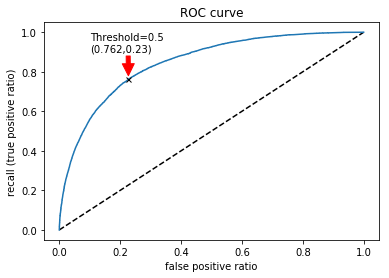

In [98]:
# Plot ROC curve for the training data set

# Classifier
clf = LogisticRegression(class_weight='balanced',random_state=21)

# Fit pipeline to training set
clf.fit(X2_train,y2_train)

# Compute probability estimates
y_predict_proba = clf.predict_proba(X2_train)

# Compute true positive ratio (recall) and false positive ratio
fpr, tpr, thresholds = roc_curve(y2_train,y_predict_proba[:,1])

# Find the false positive ratio corresponding to recall 0.676
a = np.argwhere(np.round(tpr,3)==0.762)[0]
b = np.float(fpr[a])

# Plot ROC curve and the point corresponding to threshold  = 0.5
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.plot(b,0.762,marker='x',markersize=5,color='black')
plt.annotate('Threshold=0.5 \n(0.762,%.2f)'%b,(b,0.78),(0.1,0.9),arrowprops={'color':'red'})
plt.xlabel('false positive ratio')
plt.ylabel('recall (true positive ratio)')
plt.title('ROC curve')
plt.show()

#### The slope of the curve is low after the spotted point as the curve moves toward the upper right corner. In other words, small increase in recall will result in large increase in false positive ratio. Therefore, I will not change the threshold from 0.5.

## The final logistic regression model uses threshold 0.5 to predict if a customer will be retained. The parameters of the model are C=1 and class_weight='balanced'. The model uses discretized format of numerical features instead of their original format. The average of 5-fold recall and accuracy scores of the model are 0.762 and 0.766, respectively. 

### Develop a XGBoost classifier

In [100]:
# Tree-based models are robust to highly skewed data. Therefore, the original format of data will be used.

# Compute the reverse of ratio of 1 to 0 in response variable
ratio = 1/y1_train.mean()

# Define classifier 
clf = XGBClassifier(scale_pos_weight=ratio,random_state=21)

# Two metrics are used to evaluate performance of the model: accuracy and recall.
scores = cross_validate(clf,X1_train,y1_train,cv=kfolds,scoring=['accuracy','recall'])

# Print the average of results
print('The average of 5-fold cross-validation accuracy scores for the XGBoost classifier is %.3f '%np.mean(scores['test_accuracy']))
print('The average of 5-fold cross-validation recall scores for the XGBoost classifier is %.3f '%np.mean(scores['test_recall']))

The average of 5-fold cross-validation accuracy scores for the XGBoost classifier is 0.725 
The average of 5-fold cross-validation recall scores for the XGBoost classifier is 0.838 


In [101]:
#Tune hyper parameters

# Define parameter
parameters = {'n_estimators':[50,100,200],'learning_rate':[0.05,0.1,0.2],'max_depth':[3,4,5],'subsample':[0.6,0.8,1],
             'colsample_bytree':[0.4,0.7,1]}

# 3 stratified folds are defined to be used as cross-validation splitting strategy. Three fold is used instead of the
# typical 5-fold to speed up the process.
kfold3 = StratifiedKFold(n_splits=3,random_state=21) 

cv = RandomizedSearchCV(clf,parameters,cv=kfold3,n_iter=50,scoring='recall') 
cv.fit(X1_train,y1_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=False),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=21, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=4.09925666812418, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5], 'subsample': [0.6, 0.8, 1], 'colsample_bytree': [0.4, 0.7, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall', verbose=0)

In [102]:
# Print the results
print('The best score in parameter tuning of XGBoost classifier is: %.3f'%cv.best_score_)
print('The best hyper parameter values of XGBoost classifier are: ',cv.best_params_)  

The best score in parameter tuning of XGBoost classifier is: 0.846
The best hyper parameter values of XGBoost classifier are:  {'subsample': 1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [107]:
# Define classifier with tuned hyper parameters 
clf = XGBClassifier(scale_pos_weight=ratio,random_state=21,n_estimators=50,max_depth=3,learning_rate=0.05,
                                subsample=1,colsample_bytree=1)

# Run cross_validate to find the accuracy score of the final classifier
scores = cross_validate(clf,X1_train,y1_train,cv=kfolds,scoring=['accuracy','recall'])

# Print the average of results
print('The average of 5-fold cross-validation accuracy scores for the XGBoost classifier with tuned hyper parameters is %.3f '
        %np.mean(scores['test_accuracy']))
# Print the average of results
print('The average of 5-fold cross-validation recall scores for the XGBoost classifier with tuned hyper parameters is %.3f '
        %np.mean(scores['test_recall']))

The average of 5-fold cross-validation accuracy scores for the XGBoost classifier with tuned hyper parameters is 0.695 
The average of 5-fold cross-validation recall scores for the XGBoost classifier with tuned hyper parameters is 0.845 


## The average of 5-fold recall and accuracy scores of the final XGBoost classifier with tuned hyper parameters are 0.845 and 0.695, respectively, i. e. the recall scored has improved around 11% compared to the logistic regression model while the accuracy score has dropped 9%. Since the recall score is more important, the XGBoost classifier is chosen as the final classifier.

In [112]:
# Define final classifier
final_classifier = clf

# Fit classifier on train set
final_classifier.fit(X1_train,y1_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=21, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=4.09925666812418, seed=None, silent=True,
       subsample=1)

The number of features with importance more than 0 is  17


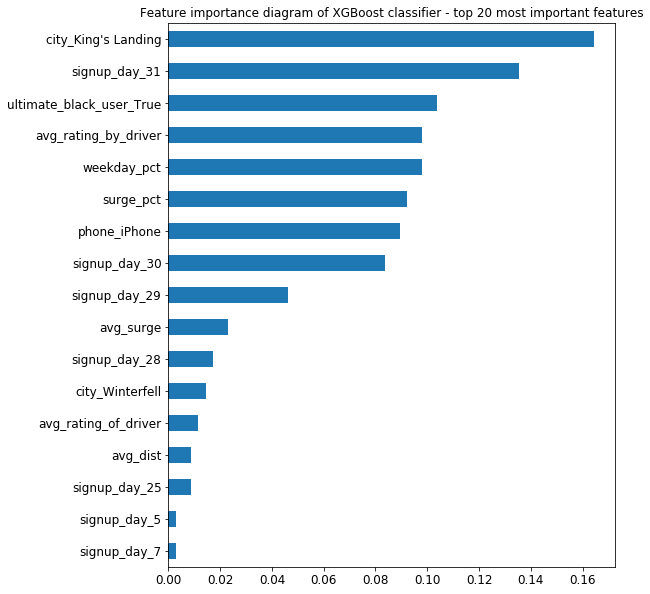

In [117]:
# Store features and their importances in a dataframe
features = pd.DataFrame(final_classifier.feature_importances_, index = X1_train.columns,
                            columns=['importance']).sort_values('importance',ascending=True)

# Create a list of features with importance higher than 0
features = features.loc[features.importance>0]

# Print the number of important features
print('The number of features with importance more than 0 is ',len(feature))

# Plot the feature importance diagram.
features.plot.barh(figsize=(8,10),legend=False)
plt.tick_params(axis='both', labelsize=12)
plt.title ('Feature importance diagram of XGBoost classifier - top 20 most important features')
plt.show()

In [118]:
# Predict the response variable of the test set
y1_predict = final_classifier.predict(X1_test)

# Print recall and accuracy scores of the test set
print('The accuracy score of the test set is %.3f'%accuracy_score(y1_test,y1_predict))
print('The recall score of the test set is %.3f'%recall_score(y1_test,y1_predict))

The accuracy score of the test set is 0.689
The recall score of the test set is 0.837


#### The recall and accuracy scores of the test set are quite close to the average of 5-fold cross validation of the corresponding scores for the train set